In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import pprint
import scipy
import tensorflow as tf

from sklearn.model_selection import train_test_split
from edward.models import Bernoulli, Normal, MultivariateNormalTriL

In [2]:
class FLAGS:
    N=1000   # Number of data points
    D=1     # Number of features

In [3]:
# Generate covariates X (N x D matrix) and binary responses y (length-N vector)
# Coefficient vector w (length-D vector) is randomly generated and private to this method
def build_toy_dataset(N, D, noise_std=1):
    X = np.random.uniform(-6, 6, size=(N, D))
    w = np.random.uniform(-1, 1, size=D)
    b = np.random.uniform(-4, 4)
    epsilon = np.random.normal(0, noise_std, size=N)
    y = (np.dot(X, w) + b + epsilon > 0).astype(int)
    # note this is actually generated from a probit model
    return X, y

In [4]:
ed.set_seed(2018)

# Generate all data at once from same model, then split it into two halves:
# (X_train, y_train) represents existing data
# (X_next, y_next) represents data not yet available
# We will choose which observation to collect from X_next, using active learning
X_all, y_all = build_toy_dataset(2*FLAGS.N, FLAGS.D)
X_train, X_next, y_train, y_next = train_test_split(X_all, y_all, train_size=FLAGS.N)

# Define model in edward (generate computation graph)
X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
b = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# Define Laplace approximation for posterior
qw = MultivariateNormalTriL(
    loc=tf.Variable(tf.random_normal([FLAGS.D])),
    scale_tril=tf.Variable(tf.random_normal([FLAGS.D, FLAGS.D])))
qb = Normal(
    loc=tf.Variable(tf.zeros([1])), 
    scale=tf.Variable(tf.ones([1])))  # should probably initialize to random values

# Perform inference
inference = ed.Laplace({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.initialize(n_print=10, n_iter=600)
inference.run()


/Users/cyz/edward/edward/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/cyz/edward/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 213.414


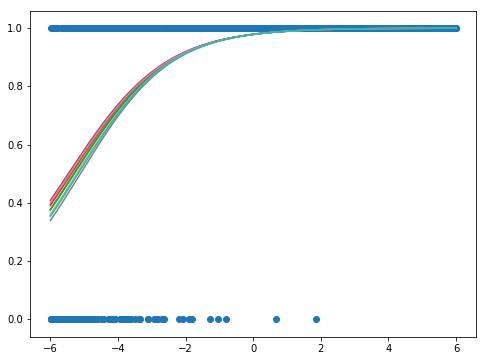

In [5]:
# Visualize samples from posterior
if FLAGS.D == 1:
    n_posterior_samples = 10

    w_post = qw.sample(n_posterior_samples).eval()
    b_post = qb.sample(n_posterior_samples).eval()

    plt.rcParams["figure.figsize"] = (8,6)
    plt.scatter(X_train, y_train)

    inputs = np.linspace(-6, 6, num=400)
    for ns in range(n_posterior_samples):
        output = scipy.special.expit(np.dot(inputs[:,np.newaxis], w_post[ns]) + b_post[ns])
        plt.plot(inputs, output)

    plt.show()

In [6]:
# Laplace approximation is centered at MAP estimate
# Retrieve MAP estimates for w and b
w_map = qw.mean().eval()
b_map = qb.loc.eval()
(w_map, b_map)

(array([0.7170981], dtype=float32), array([3.8250415], dtype=float32))

In [7]:
# Now we compute the Fisher information contribution from a new observation.
# We use edward autodifferentiation to compute the Hessian involved.
# Let's redefine the model with X, y representing a single new observation
X = tf.placeholder(tf.float32, [1, FLAGS.D])
w = Normal(loc=tf.zeros(FLAGS.D), scale=tf.ones(FLAGS.D))
b = Normal(loc=tf.zeros([1]), scale=tf.ones([1]))
y = Bernoulli(logits=ed.dot(X, w) + b)

# Construct a new variable representing the eventual value of y (symbolically)
# We need this to express the likelihood of y, so edward can take its Hessian
y_next = tf.get_variable("y_next", [1])
y_next_hess = tf.hessians(y.log_prob(y_next.value()), w)[0]

In [8]:
# Fisher information contribution from X_new
def new_point_info(X_new):
    # hessian doesn't involve y_next, so don't need to feed it in
    return -y_next_hess.eval(feed_dict={X: X_new, w: w_map, b: b_map})

In [9]:
# Compute Fisher info from existing data
observed_fisher_info = np.zeros((FLAGS.D, FLAGS.D))
for i in range(len(X_train)):
    observed_fisher_info += new_point_info(X_train[[i]])

In [10]:
observed_fisher_info

array([[1196.39753766]])

In [11]:
# This code is more complicated than it needs to be - 
# it's copied and pasted from my active learning stuff.
# Basically it compares Fisher information matrices using 
# optimal design criteria (A-, D- or E-optimality);
# see opt_criteria_comparators.

from collections import namedtuple

OptCriteria = namedtuple('OptCriteria', ['trace', 'logdet', 'max_eigval'])

# Lambda is the precision matrix
# return measures of the variance, Lambda^{-1}
def compute_opt_criteria(Lambda):
    eigvals_Lambda = np.linalg.eigvals(Lambda)
    # When there are not enough previous questions for full rank,
    # some eigenvalues will be 0. Ensure numerical stability here.
    # Originally chose threshold 1e-8, but sometimes an eigenvalue
    # that should've been 0 exceeded this threshold.
    # TODO: handle in a safer way.
    eigvals_Lambda[eigvals_Lambda < 1e-6] = 1e-6
    eigvals_Var = 1.0 / eigvals_Lambda
    return OptCriteria(
        trace = np.sum(eigvals_Var),
        logdet = np.sum(np.log(eigvals_Var)),
        max_eigval = np.max(eigvals_Var)
    )

opt_criteria_comparators = dict(
    A = lambda o1, o2: o1.trace - o2.trace,
    D = lambda o1, o2: o1.logdet - o2.logdet,
    E = lambda o1, o2: o1.max_eigval - o2.max_eigval
)

def cmp_criteria_for(optimality_type):
    return opt_criteria_comparators[optimality_type]


In [12]:
# Item selection
# Which observation from (X_next, y_next) will contribute most information,
# according to A-optimality? (Minimize trace of inverse Fisher information)
Lambda_prev = observed_fisher_info
best_new, best_opt_criteria = None, None
cmp_criteria = cmp_criteria_for('A')

for i in range(FLAGS.N):
    X_cand = X_next[[i]]
    Lambda_cand = Lambda_prev + new_point_info(X_cand)
    opt_criteria = compute_opt_criteria(Lambda_cand)
    
    if best_opt_criteria is None or cmp_criteria(opt_criteria, best_opt_criteria) < 0:
        best_new = i
        best_opt_criteria = opt_criteria

In [13]:
best_new, X_next[[best_new]]

(483, array([[-5.99008197]]))